In [3]:
import configparser

parser = configparser.ConfigParser()
parser.read('config.ini')

['config.ini']

In [4]:
import sys
import pandas as pd
import numpy as np
import os
import traceback
import pdb
import matplotlib.pyplot as plt
np.seterr(all="ignore")
plt.rcParams['text.usetex'] = True

#--- user libs
sys.path.append(parser['py library directory']['path'])
import utility as utl
import imp
imp.reload(utl)
import LammpsPostProcess2nd as lp
imp.reload(lp)

class Symbols:
    def __init__(self):
        self.colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
        self.fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
        self.markers=['o','s','D','^','<','>','v']
        self.markersizes=[10,10,10,12,12,12,10]
        self.nmax=7
        
    def GetAttrs(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':self.colors[count],
            'markeredgecolor':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
             'zorder':zorder,
         }
        return attrs
    
    def GetAttrs2nd(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':'white',
#            'markeredgecolor':'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
            'zorder':zorder,
          }
        return attrs

class Legends:
    def __init__(self
                ):
        pass
    def Set(self,fontsize=20,
                 labelspacing=0,
                 **kwargs
#                 bbox_to_anchor=(0.5,0.48,0.5,0.5),
           ):
        self.attrs = {'frameon':False,'fontsize':fontsize,
                   'labelspacing':labelspacing,
                      'handletextpad':.2,
                   'handlelength':1,
                    **kwargs,
                     }
    def Get(self):
        return self.attrs

# parse data

In [5]:
path=parser['test data directory']['path']
#
inputFiles = os.listdir('%s'%(path))
print('inputFiles=',np.array(inputFiles))

inputFiles= ['tensileCantor_tensile900_1_rate2.dump'
 'tensileCantor_tensile900_1_rate2_2nd.gz'
 'tensileCantor_tensile900_1_rate2.txt'
 'tensileCantor_tensile900_1_rate2.gz']


## parse dump file

In [4]:
print('parsing %s/%s:'%(path,inputFiles[0]))
lmpData = lp.ReadDumpFile('%s/%s'%(path,inputFiles[0]),verbose=True)
lmpData.GetCords(ncount=sys.maxsize)
#--- print
keys = list(lmpData.coord_atoms_broken.keys())
keys.sort()
display(lmpData.coord_atoms_broken[keys[0]])

parsing ../testdata/aedata/cantor/rate/tensileCantor_tensile900_1_rate2.dump:
itime=110000
itime=120000
itime=130000
itime=140000
itime=150000
itime=160000
itime=170000
itime=180000
itime=190000
itime=200000
itime=210000
itime=220000
itime=230000
itime=240000
itime=250000
itime=260000
itime=270000
itime=280000
itime=290000
itime=300000
itime=310000
itime=320000
itime=330000
itime=340000
itime=350000
itime=360000
itime=370000
itime=380000
itime=390000
itime=400000
itime=410000
itime=420000
itime=430000
itime=440000
itime=450000
itime=460000
itime=470000
itime=480000
itime=490000
itime=500000
itime=510000
itime=520000
itime=530000
itime=540000
itime=550000
itime=560000
itime=570000
itime=580000
itime=590000
itime=600000
itime=610000
itime=620000
itime=630000
itime=640000
itime=650000
itime=660000
itime=670000
itime=680000
itime=690000
itime=700000
itime=710000
itime=720000
itime=730000
itime=740000
itime=750000
itime=760000
itime=770000
itime=780000
itime=790000
itime=800000
itime=810000

,id,type,x,y,z,c_mystress[1],c_mystress[2],c_mystress[3],c_mystress[4],c_mystress[5],c_mystress[6]
0,1,2,-0.699041,88.931900,81.27170,496290.0,193769.0,-487008.0,73819.3,881629.0,-596108.0
1,2,2,2.170160,-0.912803,3.24537,387260.0,151586.0,85547.0,755941.0,-450220.0,-731634.0
2,3,4,0.890579,89.084300,1.17263,-2376250.0,-873547.0,-758410.0,1680010.0,126122.0,-182146.0
3,4,5,1.377280,0.369775,81.14200,-276388.0,-364282.0,-833265.0,105317.0,301028.0,-359723.0
4,5,2,3.076460,0.481907,1.10135,-36436.6,-484264.0,1133720.0,484431.0,220016.0,-419807.0
...,...,...,...,...,...,...,...,...,...,...,...
54595,54596,4,86.477900,86.344600,79.26450,1090890.0,177741.0,962106.0,-91883.1,-188682.0,-545396.0
54596,54597,3,85.089700,86.364300,77.00590,-972425.0,-1626630.0,746764.0,596463.0,327356.0,226046.0
54597,54598,4,85.887300,87.833300,74.75540,-1897680.0,-1182910.0,791592.0,18364.6,214432.0,-51554.9
54598,54599,2,87.090500,87.722300,76.98460,990794.0,708455.0,1458820.0,-159423.0,-259193.0,329049.0


## Parse load curves

In [5]:
#--- read input file
# loadTimeSeries=list(map(lambda x:pd.DataFrame(np.c_[np.loadtxt('%s/%s'%(path,x))],
#                 columns=['Time','Stress']),inputFiles))
# loadTimeSeries[0] #--- index indicates the indenter location

loadTimeSeries=pd.DataFrame(np.c_[np.loadtxt('%s/%s'%(path,inputFiles[3]),max_rows=1000000)],
                columns=['strain','press','szz','sxx','syy','sxy','syz','sxz','vol']
                           )
loadTimeSeries #--- index indicates the indenter location

,strain,press,szz,sxx,syy,sxy,syz,sxz,vol
0,5.207836e-16,0.025216,-0.025216,0.033828,0.022617,0.029370,-0.024653,0.002555,6307.580652
1,4.000000e-07,0.025199,-0.025199,0.034803,0.024648,0.028185,-0.025421,0.002110,6306.662938
2,8.000000e-07,0.024524,-0.024524,0.035817,0.026686,0.026907,-0.026056,0.001806,6305.895478
3,1.200000e-06,0.023568,-0.023568,0.036781,0.028682,0.025565,-0.026646,0.001268,6305.293550
4,1.600000e-06,0.022926,-0.022926,0.037437,0.030658,0.024344,-0.027108,0.000463,6304.867713
...,...,...,...,...,...,...,...,...,...
999995,3.999980e-01,-3.171245,3.209660,-0.166232,-0.019813,0.054342,0.454877,-0.043641,6374.125125
999996,3.999984e-01,-3.169890,3.208284,-0.168283,-0.016829,0.054855,0.454784,-0.042232,6373.895990
999997,3.999988e-01,-3.168105,3.206472,-0.170307,-0.013673,0.055076,0.454742,-0.040959,6373.503392
999998,3.999992e-01,-3.166039,3.204375,-0.171836,-0.010676,0.055206,0.454571,-0.039693,6372.958534


# Plot timeseries

## output timeseries

mkdir: png: File exists


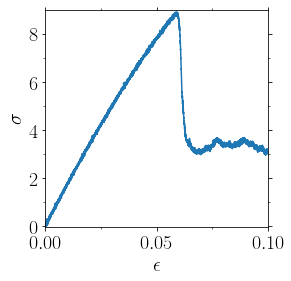

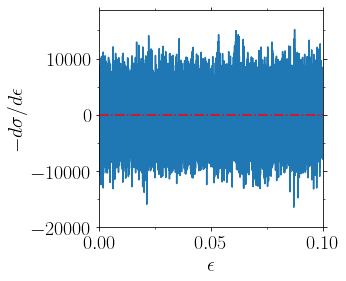

<AxesSubplot:xlabel='$\\epsilon$', ylabel='$-d\\sigma/d\\epsilon$'>

In [6]:
!mkdir png

#--- set limits
index = 0 #--- file index
ld = loadTimeSeries#[ index ] #--- file id
# indentLabel, grainID = GetGrainId(indent,indentLabels,loadID,index)
# print('indent label:%s, grain id:%s'%(indentLabel,grainID))

#--- time
tlo = 0.0 #ld.Time.min()
thi = 0.1 #ld.strain.max() #ld.Time.max()
filtr=np.all([ld['strain']<thi,ld['strain']>=tlo],axis=0)
# #--- load
flo = 0.99*ld['szz'][filtr].min()
fhi = 1.01*ld['szz'][filtr].max() #ld.Force.max()

#--- load vs. time
utl.PltErr(ld.strain, ld.szz,
           attrs={'fmt':'-'},
            xlim=(tlo,thi),
            ylim=(flo,fhi),
           xstr=r'$\epsilon$',
           ystr=r'$\sigma$',
           title='png/stress_timeseries.png'
          )

ax=utl.PltErr(ld.strain, -np.gradient(ld.szz,ld.strain),
           attrs={'fmt':'-'},
            Plot=False,
          )

utl.PltErr([tlo,thi],[0,0],
           attrs={'fmt':'-.r'},
            xlim=(tlo,thi),
#            ylim=(flo,fhi),
           xstr=r'$\epsilon$',
           ystr=r'$-d\sigma/d\epsilon$',
           ax=ax,
           title='png/stress_derivative.png'
          )


## load curve (dump file)

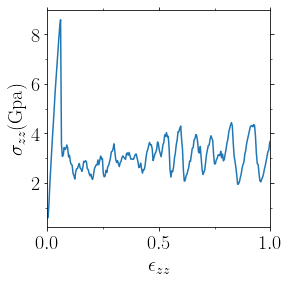

<AxesSubplot:xlabel='$\\epsilon_{zz}$', ylabel='$\\sigma_{zz}(\\mathrm{Gpa})$'>

In [7]:
#--- timesteps
keys = list(lmpData.coord_atoms_broken.keys())
keys.sort()

#--- stress
szz = list(map(lambda x:lmpData.coord_atoms_broken[x]['c_mystress[3]'].sum(),keys))

#--- strain
box = lp.Box(BoxBounds=lmpData.BoxBounds[keys[0]],
      AddMissing=np.array([0,0,0])
      )

lz0 = box.CellVector[2,2]
ezz = list(map(lambda x:lp.Box(BoxBounds=lmpData.BoxBounds[x],AddMissing=np.array([0,0,0])).CellVector[2,2]/lz0-1,
               keys))

#--- volume
vol = list(map(lambda x:np.linalg.det(lp.Box(BoxBounds=lmpData.BoxBounds[x],AddMissing=np.array([0,0,0])).CellVector),
               keys))

dmpStrs=pd.DataFrame(np.c_[keys,np.array(ezz+ezz[1]-ezz[0]),1e-4*np.array(szz)/vol],columns=['timestep','strain','szz'])

#--- plot
symbols=Symbols()
ax=utl.PltErr(None,#loadTimeSeries['strain'],
          None,#loadTimeSeries['szz'],
           fmt='-',
              Plot=False,
          
          )
utl.PltErr(dmpStrs.strain,dmpStrs.szz,
#            attrs=symbols.GetAttrs(count=0,fmt='.-'),
           attrs={'fmt':'-','color':'C0'},
          ax=ax,
            xlim=(0.0,1.0),
#            ylim=(2,3)
           xstr=r'$\epsilon_{zz}$',
           ystr=r'$\sigma_{zz}(\mathrm{Gpa})$',
           title='png/stress_strain.png'
          )



# Avalanche statistics

## Avalanche size

In [8]:
def GetAvl( t,x, y, lambdc ):
    n = len(x)
    i = 0
    smat = [[],[],[],[],[]]
    try:
        while True:
            while y[i] < lambdc:
                i += 1
            assert y[i] >= lambdc
            #--- avalanche starts
            dur = 0
#            size = 0.0 #y[i]
            start = x[i]
            start_indx = i
            start_t = t[i]
            while y[i]>=lambdc: #-x[i] == 1:
                dur += 1
#                size += (y[i]-lambdc)
                i += 1
            #--- avalanche ends
            assert y[i] < lambdc
            end = x[i] #x[i-1 if i-1 >= 0 else 0]
            end_indx = i #i-1 if i-1>= 0 else 0
            end_t = t[i] #i-1 if i-1>= 0 else 0
            #--- size
            sub_x = x[start_indx:end_indx+1]
            sub_y = y[start_indx:end_indx+1]
            size = np.sum((sub_x[1:]-sub_x[:-1])*sub_y[:-1])
#            print start, end, size
            #--- find epicenter
            smat = np.c_[smat,[start, end, start_t, end_t, size]]
    except:
#        traceback.print_exc()
        pass

    assert smat.shape[1] > 0, 'Lower lambdc! lambdc='%lambdc
    df_avl = pd.DataFrame(smat.T,columns=['ei','ef','ti','tf','size'])
    df_avl=df_avl[df_avl['size']>0]
    return df_avl


# of avalanches:35


../../../CrystalPlasticity/postprocess/utility.py:2098: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  ax.errorbar( xdata, ydata,yerr = yerr, xerr = xerr, **kwargs['attrs'])


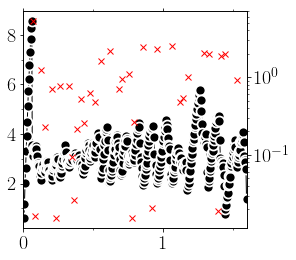

<AxesSubplot:>

In [9]:
def Wrapper_GetAvl(t,x,y,tlo,thi,lambdc):
    '''
    return avalanche sizes given force timeseries and initial and final times
    '''
    
#    print(np.min(GetPower(ld,tlo,thi)))
    
    #--- data frame storing avalanche attributes
    filtr = np.all([x>tlo,x<thi],axis=0)

    df_avl = GetAvl( t,np.array(x[filtr]), -np.gradient(y,x)[filtr], lambdc)
    print('# of avalanches:%s'%df_avl.shape[0])
    #df_avl = GetAvalKunMethod( broken_bonds,  5) #tcrltn )

    #--- save
    # df_fltrd = DataFrameSubSet( df_avl, #--- filter
    #                               'ti', 
    #                               ( 0, tavl ) ) 
    # df_fltrd.to_pickle('df_avl.pk')

    df_avl.sort_values( by = 'size',ascending = False,inplace=True)
#    print ('n.avls = %s'%len(df_avl))
    return df_avl #np.array(df_avl['size'].to_list())
    
lambdc = 0.0 #--- threshold
temps=['900'] #'300','700','900','600','800']
tlo = 0.0
thi = dmpStrs.strain.max()
try:
#    df_avl = np.concatenate(list(map(lambda x:Wrapper_GetAvl(x,tlo,thi,lambdc), loadTimeSeries)))
    df_avl = dict(zip(temps,list(map(lambda x:Wrapper_GetAvl(x.timestep,x.strain,x.szz,tlo,thi,lambdc), [dmpStrs]))))
#    print('df_avl.shape:%s'%df_avl['300'].shape[0])
#    df_avl = Wrapper_GetAvl(ld,tlo,thi,lambdc)
except:
    traceback.print_exc()
    print('increase the threshold')
    
    
df_avl = df_avl['900']
ax=utl.PltErr(dmpStrs.strain,dmpStrs.szz,
            attrs=symbols.GetAttrs(count=0),
              Plot=False,
            xlim=(tlo,thi),
#            ylim=(2,3)
          )
utl.PltErr(df_avl['ef'],df_avl['size'],
           attrs={'fmt':'x','color':'red'},
#             xlim=(tlo,thi),
#            ylim=(flo,fhi),
           ax=ax.twinx(),
#           xstr=r'$\epsilon$',
#           ystr=r'$s$',
           yscale='log',
            xlim=(tlo,thi),
#           title='png/size.png'
          )


### strain map

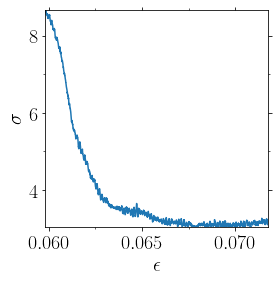

<AxesSubplot:xlabel='$\\epsilon$', ylabel='$\\sigma$'>

In [10]:
#--- strain window
tif=df_avl.iloc[0][['ei','ef']]
filtr=np.all([dmpStrs['strain']<tif['ef'],dmpStrs['strain']>=tif['ei']],axis=0)
# #--- load
flo = 0.99*dmpStrs['szz'][filtr].min()
fhi = 1.01*dmpStrs['szz'][filtr].max() #ld.Force.max()

#--- load vs. time
ydata = loadTimeSeries
utl.PltErr(ydata.strain, ydata.szz,
           attrs={'fmt':'-'},
            xlim=(tif['ei'],tif['ef']),
            ylim=(flo,fhi),
           xstr=r'$\epsilon$',
           ystr=r'$\sigma$',
          )

### local strain

In [11]:
def WrapperStrain(lmpData,reference_frames,current_frames, dim=3):
    '''
    invoke strain analysis in ovito
    '''
    #--- split dump file
    for ii0, ii in zip(reference_frames,current_frames):
        atom_current = lp.Atoms(**lmpData.coord_atoms_broken[ii])
        atom_reference = lp.Atoms(**lmpData.coord_atoms_broken[ii0])
        box  = lp.Box( BoxBounds = lmpData.BoxBounds[ii],  AddMissing = np.array([0.0,0.0,0.0] ))
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[ii0], AddMissing = np.array([0.0,0.0,0.0] ))
        lp.WriteDumpFile(atom_current, box).Write('strain/dump_curr.xyz', itime = ii,
                 attrs=['id', 'type','x', 'y', 'z'],
                 fmt='%i %i %15.14e %15.14e %15.14e')

        lp.WriteDumpFile(atom_reference, box0).Write('strain/dump_ref.xyz', itime=ii0,
             attrs=['id', 'type','x', 'y', 'z'],
             fmt='%i %i %15.14e %15.14e %15.14e')
        fileCurr = 'strain/dump_curr.xyz'
        fileRef = 'strain/dump_ref.xyz'
        output = 'strain/d2min.%s.xyz'%ii
        #--- load to ovito
        os.system('ovitos %s/OvitosCna.py %s %s 2 5 %s'%(parser['py library directory']['path'],
                                                         fileCurr,output,fileRef))
        #--- concat
        os.system('cat %s >> strain/strain.xyz;rm %s'%(output,output))

        
!mkdir strain
try:
    os.system('rm strain/strain.xyz')
except:
    pass
#--- current
current_frames = np.c_[df_avl['tf']].astype(int).flatten()
print('current_frames=',current_frames)
#--- reference
reference_frames = np.c_[[df_avl['ti']]].astype(int).flatten()
print('reference_frames=',reference_frames)

#--- call function
WrapperStrain(lmpData,reference_frames,current_frames)

#--- parse
lmpStrn = lp.ReadDumpFile( 'strain/strain.xyz' )
lmpStrn.GetCords( ncount = sys.maxsize )

mkdir: strain: File exists
current_frames= [ 280000 2770000 2250000 2500000 1650000 3340000 3720000 3420000 3650000
 1500000  410000 1990000 3050000 1860000 3930000  750000  910000  610000
 1810000 1300000 2970000 1140000 1380000 2910000 2090000 1180000  490000
 1070000  980000 1010000 2410000 3580000  310000 2040000  690000]
reference_frames= [ 250000 2660000 2170000 2430000 1600000 3270000 3660000 3370000 3600000
 1440000  330000 1950000 3010000 1820000 3890000  710000  850000  540000
 1780000 1260000 2930000 1100000 1350000 2880000 2050000 1150000  460000
 1020000  960000 1000000 2400000 3570000  300000 2030000  680000]
InputFile= strain/dump_curr.xyz
OutputFile= strain/d2min.280000.xyz
nevery 2
InputFile= strain/dump_curr.xyz
num_frames= 1
frame=0/1
InputFile= strain/dump_curr.xyz
OutputFile= strain/d2min.2770000.xyz
nevery 2
InputFile= strain/dump_curr.xyz
num_frames= 1
frame=0/1
InputFile= strain/dump_curr.xyz
OutputFile= strain/d2min.2250000.xyz
nevery 2
InputFile= strain/dump_c

### d2min

In [11]:
def WrapperD2min(lmpData,reference_frames,current_frames, dim=3):
    '''
    invoke d2min analysis in ovito
    '''
    #--- split dump file
    for ii0, ii in zip(reference_frames,current_frames):
        atom_current = lp.Atoms(**lmpData.coord_atoms_broken[ii])
        atom_reference = lp.Atoms(**lmpData.coord_atoms_broken[ii0])
        box  = lp.Box( BoxBounds = lmpData.BoxBounds[ii],  AddMissing = np.array([0.0,0.0,0.0] ))
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[ii0], AddMissing = np.array([0.0,0.0,0.0] ))
        if dim == 3:
            lp.WriteDumpFile(atom_current, box).Write('D2minAnl/dump_curr.xyz', itime = ii,
                 attrs=['id', 'type','x', 'y', 'z'],
                 fmt='%i %i %15.14e %15.14e %15.14e')
            lp.WriteDumpFile(atom_reference, box0).Write('D2minAnl/dump_ref.xyz', itime=ii0,
                 attrs=['id', 'type','x', 'y', 'z'],
                 fmt='%i %i %15.14e %15.14e %15.14e')
        else:
            lp.WriteDumpFile(atom_current, box).Write('D2minAnl/dump_curr.xyz', itime = ii,
                 attrs=['id', 'type','x', 'y'],
                 fmt='%i %i %15.14e %15.14e')
            lp.WriteDumpFile(atom_reference, box0).Write('D2minAnl/dump_ref.xyz', itime=ii0,
                 attrs=['id', 'type','x', 'y'],
                 fmt='%i %i %15.14e %15.14e')
    #    os.system('tar czf dump.gz dump.xyz')
        fileCurr = 'D2minAnl/dump_curr.xyz'
        fileRef = 'D2minAnl/dump_ref.xyz'
        output = 'D2minAnl/d2min.%s.xyz'%ii
        #--- load to ovito
        os.system('ovitos %s/OvitosCna.py %s %s 2 2 %s'%(parser['py library directory']['path'],
                                                         fileCurr,output,fileRef))
        #--- concat
        os.system('cat %s >> D2minAnl/d2min.xyz;rm %s'%(output,output))

        
        
        
#    assert nevery < len(lmpData.coord_atoms_broken.keys()), 'decrease nevery!'
!mkdir D2minAnl
try:
    os.system('rm D2minAnl/d2min.xyz')
except:
    pass

#--- assign frames
#--- current
current_frames = np.c_[df_avl['tf']].astype(int).flatten()
print('current_frames=',current_frames)
#--- reference
reference_frames = np.c_[[df_avl['ti']]].astype(int).flatten()
print('reference_frames=',reference_frames)

#--- call function
WrapperD2min(lmpData,reference_frames,current_frames)
#--- parse
lmpDmin = lp.ReadDumpFile( 'D2minAnl/d2min.xyz' )
lmpDmin.GetCords( ncount = sys.maxsize, columns = {'NonaffineSquaredDisplacement':'d2min'} )

mkdir: D2minAnl: File exists
current_frames= [ 280000 2770000 2250000 2500000 1650000 3340000 3720000 3420000 3650000
 1500000  410000 1990000 3050000 1860000 3930000  750000  910000  610000
 1810000 1300000 2970000 1140000 1380000 2910000 2090000 1180000  490000
 1070000  980000 1010000 2410000 3580000  310000 2040000  690000]
reference_frames= [ 250000 2660000 2170000 2430000 1600000 3270000 3660000 3370000 3600000
 1440000  330000 1950000 3010000 1820000 3890000  710000  850000  540000
 1780000 1260000 2930000 1100000 1350000 2880000 2050000 1150000  460000
 1020000  960000 1000000 2400000 3570000  300000 2030000  680000]
InputFile= D2minAnl/dump_curr.xyz
OutputFile= D2minAnl/d2min.280000.xyz
nevery 2
InputFile= D2minAnl/dump_curr.xyz
num_frames= 1
frame=0/1
InputFile= D2minAnl/dump_curr.xyz
OutputFile= D2minAnl/d2min.2770000.xyz
nevery 2
InputFile= D2minAnl/dump_curr.xyz
num_frames= 1
frame=0/1
InputFile= D2minAnl/dump_curr.xyz
OutputFile= D2minAnl/d2min.2250000.xyz
nevery 2
InputF

### plot

In [12]:
def quantile(slist,q):
    slist.sort()
    n=len(slist)
    return slist[int(q*n):][0]


#--- print 
!rm D2minAnl/d2min_avalanche.xyz
keys=list(lmpDmin.coord_atoms_broken.keys())
keys.sort()
sfile=open('D2minAnl/d2min_avalanche.xyz','a')
for time in keys:
    dmin_log = np.log10(lmpDmin.coord_atoms_broken[time].d2min)
    filtr = dmin_log >= quantile(list(dmin_log),0.95)
    atom = lp.Atoms(**(lmpDmin.coord_atoms_broken[time][filtr]))
    box  = lp.Box( BoxBounds = lmpData.BoxBounds[time],  AddMissing = np.array([0.0,0.0,0.0] ))
    atom.NonaffineSquaredDisplacement = list(dmin_log[filtr])
        
    #
    lp.WriteDumpFile(atom, box).Write(sfile, itime = time,
         attrs=['id', 'type','x', 'y', 'z','NonaffineSquaredDisplacement'],
         fmt='%i %i %f %f %f %f')
sfile.close()

### pdf

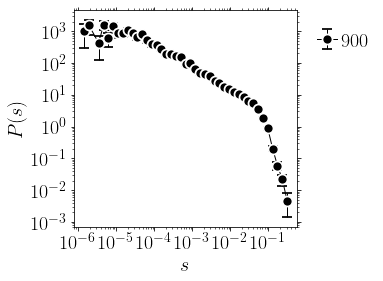

<AxesSubplot:xlabel='$s$', ylabel='$P(s)$'>

In [40]:
ax = utl.PltErr(None,None,Plot=False)
symbols=Symbols()
legend=Legends()
legend.Set(fontsize=20,
                 labelspacing=0,
                 bbox_to_anchor=(.9,0.48,0.5,0.5),
           )

alpha=1.0
for count,temp in zip(range(len(df_avl)),['900']): #--- different temperatures
    sizes = df_avl[temp]['size']
    smax = np.max(sizes)
    hist, edge, err = utl.GetPDF(sizes, n_per_decade=8, linscale=None)

    utl.PltErr(edge, 
               10**count*hist,#*edge**alpha, 
               yerr=10**count*err,#*edge**alpha,
               Plot=False,ax=ax,
               attrs=symbols.GetAttrs(count=count,label=r'$%s$'%temp))

utl.PltErr(None, None,
           attrs={'fmt':'-.r'},
#           ystr=r'$P(s).s^{%s}$'%alpha,
           ystr=r'$P(s)$',
           xstr=r'$s$',
           xscale = 'log',
           yscale='log',
#           xlim=(1.0e-6,.2),
#           ylim=(1e-1,1e8),#(1e-3,1e4),
           ax=ax,
           title='png/ps.png',
            legend=legend.Get()
          )

### vary threshold

# of avalanches:726
# of avalanches:726
# of avalanches:728
# of avalanches:728
# of avalanches:718
# of avalanches:391


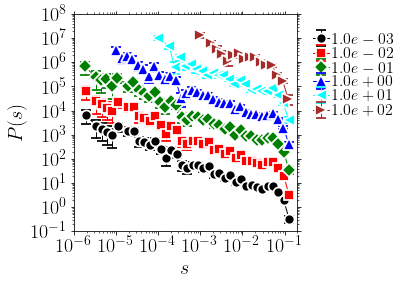

<AxesSubplot:xlabel='$s$', ylabel='$P(s)$'>

In [186]:
def varyThreshold(loadTimeSeries, tlo, thi, lambdc):
    return np.concatenate(list(map(lambda x:Wrapper_GetAvl(x,tlo,thi,lambdc)['size'], loadTimeSeries)))

legend=Legends()
legend.Set(fontsize=16,
                 labelspacing=0,
                 bbox_to_anchor=(1,0.48,0.5,0.5),
           )
#
alpha=1.0
#
lambdc = np.logspace(np.log10(1.0e-3),np.log10(1.0e2),6)
size_lambdc = list(map(lambda x:varyThreshold([loadTimeSeries[0]], tlo, thi, x),lambdc))

#--- distributions
hists = list(map(lambda x: utl.GetPDF(x, n_per_decade=8, linscale=None), size_lambdc))

ax = utl.PltErr(None,None,Plot=False)
for item, threshold, indx in zip(hists, lambdc, range(len(hists))):
    hist, edge, err = item
    ax=utl.PltErr(edge, 
                  10**indx*hist,#*edge**alpha, 
                  yerr=10**indx*err,#*edge**alpha,
                   attrs=symbols.GetAttrs(count=indx%7,label=r'$%2.1e$'%threshold),
                    Plot = False,
                    ax=ax,
                  )
utl.PltErr(None,None,
#    edge, 1e-1/edge**alpha,
#           attrs={'fmt':'-.r'},
            legend=legend.Get(),
#           ystr=r'$P(s).s^{%s}$'%alpha,xstr=r'$s$',
           ystr=r'$P(s)$',xstr=r'$s$',
           xscale = 'log',yscale='log',
           xlim=(1.0e-6,.2),ylim=(1e-1,1e8), #hist.min(),hist.min()*1e8),
           ax=ax,
           title='png/ps.png',
          )

[ 1.25007966 -0.53496973 12.76198166]


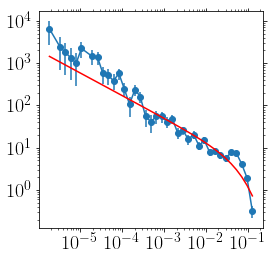

<AxesSubplot:>

In [170]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * x**b * np.exp(-c * x)
def func2(x, a, b):
    return a * x**b

xdata = edge
ydata = hist
yerr=err
ax = utl.PltErr(xdata, ydata, yerr=yerr, label='data',Plot=False)
popt, pcov = curve_fit(func, xdata, ydata,
                      bounds=((1e-3,-4,1e-3), (np.infty, 0, 100.0)),
                       p0=(1,-1,10.0),
                       sigma=err,
                      )
print(popt)
utl.PltErr(xdata, func(xdata, *popt), attrs={'fmt':'r-'},
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt),
        ax=ax,
           xscale='log',yscale='log',
          )



In [348]:
input_file = '/Users/Home/Desktop/Tmp/txt/git/DislocationAvalanches/nanoindentation/ebsd/attributes.txt'
grain_attr = pd.read_csv(input_file,sep='\t')
grain_attr.head()

,#grainID,x,y,grainSize,perimeter,boundarySize,numNeighbors
0,1,-0.018954,0.068387,1,3.695012,5,1
1,2,-85.909030,-0.799994,1,2.771259,6,1
2,3,-85.909030,-2.399981,1,2.771259,6,2
3,4,-141.335700,-0.852774,10,13.056300,24,3
4,5,-85.909030,-3.199974,1,2.771259,6,3


In [349]:
def Wrapper(index):
    #index = 0 #--- file index
    ld = loadTimeSeries[ index ] #--- file id
    indentLabel = indentLabels[index]

    grainLabel = grainLabels[loadID][indentLabel]
    print('indent label:%s, grain label:%s'%(indentLabel,grainLabel))

    lambdc = 10.0
    avlanche = Wrapper_GetAvl(ld,tlo,thi,lambdc)
    moment_1st = np.mean(avlanche)
    avalanche_sq = avlanche*avlanche
    moment_2nd = np.mean(avalanche_sq)**0.5
    avalanche_4th = avalanche_sq*avalanche_sq
    moment_4th = np.mean(avalanche_4th)**0.25

    grainSize = grain_attr[ grain_attr['#grainID'] == grainLabel ].grainSize
#    pdb.set_trace()
    return grainSize.iloc[0], moment_1st, moment_2nd, moment_4th


#val = np.c_[list(map(lambda x:Wrapper(x),range(len(loadTimeSeries))))]
# utl.PltErr(utl.Zscore(val[:,0]),utl.Zscore(val[:,1]),
#           attrs={'fmt' : '.',
#           'markersize':10.0},
#             xstr=r'grain size',
#             ystr=r'1st moment',
#            xlim=(-3,3),
#            ylim=(-3,3),
#           )

# utl.PltErr(utl.Zscore(val[:,0]),utl.Zscore(val[:,2]),
#           attrs={'fmt' : '.',
#           'markersize':10.0},
#             xstr=r'grain size',
#             ystr=r'2nd moment',
#            xlim=(-3,3),
#            ylim=(-3,3),
#           )
# utl.PltErr(val[:,0],val[:,2],
#           attrs={'fmt' : '.',
#           'markersize':10.0},
#             xstr=r'grain size',
#             ystr=r'avalanche size(2nd moment)',
#            title='avalancheSize.png'
# #           xlim=(-3,3),
# #           ylim=(-3,3),
#           )

# utl.PltErr(utl.Zscore(val[:,0]),utl.Zscore(val[:,3]),
#           attrs={'fmt' : '.',
#           'markersize':10.0},
#             xstr=r'grain size',
#             ystr=r'4th moment',
#            xlim=(-3,3),
#            ylim=(-3,3),
#           )


# cluster analysis
+ cluster analysis of top 5% atoms with largest D2min values 

In [ ]:
!mkdir fractal 
#--- loop over timesteps
keys=list(lmpDmin.coord_atoms_broken.keys())
keys.sort()
for time in keys:
    #--- fetch data
    dmin_log = np.log10(lmpDmin.coord_atoms_broken[time].d2min)
    atom = lp.Atoms(**(lmpDmin.coord_atoms_broken[time]))
    box  = lp.Box( BoxBounds = lmpData.BoxBounds[time],  AddMissing = np.array([0.0,0.0,0.0] ))
    atom.NonaffineSquaredDisplacement = list(dmin_log)
     #-----------------
     #--- INTERPOLATE
     #-----------------
    (xlin, ylin, zlin), (xv, yv, zv), mu_intrp = utl.Intrp(atom, box, 'NonaffineSquaredDisplacement',
                Plot = None,
               )
#    mu=np.mean((atom.NonaffineSquaredDisplacement))
#    mu_std=np.std(atom.NonaffineSquaredDisplacement)

    #--- plot
    value = utl.PltBinary(
                        xlin,ylin,zlin, mu_intrp.NonaffineSquaredDisplacement,
                        box,
                        0.0, #--- threshold
                        cmap='Greys',
    #                    title='ModuAnl/negative_mu.%s.png'%itime,
                        zscore=False,
                        #DrawFrame=(0.21,0.06,0.15,0.06,0.1),
                        xlabel = 'x', ylabel = 'y',
                        labels = True,
                        Plot=False,
                     )
    print('value.shape=',value.shape)

    #---------------------
    #--- output matrix
    #---------------------
    mask = value >= quantile(list(value.flatten()),0.95)
    #mask = value<0.0 #--- threshold
    print('p=',np.sum(mask)/value.size)

    #    stats = Stats(mask, xlin, ylin, zlin)
    #    stats.GetSize()
    #    display(stats.stats)

    #--- save
    np.save('fractal/negative_mu%s'%time,mask)
    np.savetxt('fractal/xlin%s.txt'%time,np.c_[xlin,],header='xlin')
    np.savetxt('fractal/ylin%s.txt'%time,np.c_[ylin,],header='ylin')
    np.savetxt('fractal/zlin%s.txt'%time,np.c_[zlin,],header='zlin')





mkdir: fractal: File exists


In [32]:
# df = pd.DataFrame(np.c_[xv.flatten(),yv.flatten(),zv.flatten(),mask.flatten()],columns=['x','y','z','mass'])
# utl.PrintOvito( df,
#                open('ovito.xyz','w'),
#                'itime=0',
#                 attr_list=['x', 'y', 'z','mass'],

#             )

In [34]:
#     sfile=open('dump.xyz','w')
#     dmin_log = np.log10(lmpDmin.coord_atoms_broken[time].d2min)
#     filtr = dmin_log >= quantile(list(dmin_log),0.95)
#     atom = lp.Atoms(**(lmpDmin.coord_atoms_broken[time][filtr]))
#     box  = lp.Box( BoxBounds = lmpData.BoxBounds[time],  AddMissing = np.array([0.0,0.0,0.0] ))
#     atom.NonaffineSquaredDisplacement = list(dmin_log[filtr])
        
#     #
#     lp.WriteDumpFile(atom, box).Write(sfile, itime = time,
#          attrs=['id', 'type','x', 'y', 'z','NonaffineSquaredDisplacement'],
#          fmt='%i %i %f %f %f %f')
#     sfile.close()

## fractal dimension

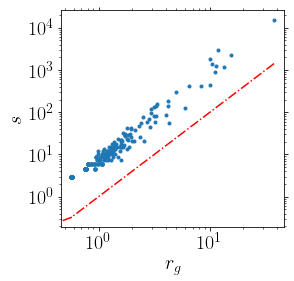

<AxesSubplot:xlabel='$r_g$', ylabel='$s$'>

In [16]:
#--- input
time = keys[0]
pathh='fractal'
stats = utl.Stats(mask=np.load('%s/negative_mu%s.npy'%(pathh,time)), 
                 xlin=np.loadtxt('%s/xlin%s.txt'%(pathh,time)), 
                 ylin=np.loadtxt('%s/ylin%s.txt'%(pathh,time)),
                 zlin=np.loadtxt('%s/zlin%s.txt'%(pathh,time)),
                )
stats.GetSize()
stats.GetProbInf()
stats.GetProb()
stats.GetSmean()
stats.GetCrltnLenSq()

#--- plot
r=stats.stats['rg_sq']**0.5
ax=utl.PltErr(r,stats.stats['size'],
          attrs={'fmt':'.'},
              Plot=False,
          )
utl.PltErr(r,r**2,
          attrs={'fmt':'r-.'},
          ax=ax,
           xscale='log',
           yscale='log',
           xstr=r'$r_g$',
           ystr=r'$s$',
          )

## stress drop and volume

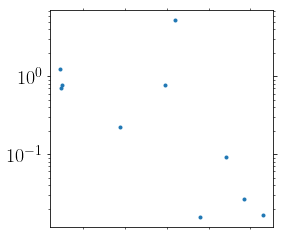

<AxesSubplot:>

In [17]:
pathh='fractal'
size=[]
volume=[]
for time in keys[:10]:
        stats = utl.Stats(mask=np.load('%s/negative_mu%s.npy'%(pathh,time)), 
                         xlin=np.loadtxt('%s/xlin%s.txt'%(pathh,time)), 
                         ylin=np.loadtxt('%s/ylin%s.txt'%(pathh,time)),
                         zlin=np.loadtxt('%s/zlin%s.txt'%(pathh,time)),
                        )
        stats.GetSize()
    #    display(stats.stats)
        stats.GetProbInf()
        stats.GetProb()
        stats.GetSmean()
        stats.GetCrltnLenSq()

        size += [df_avl[df_avl['tf'] == time].iloc[0]['size']]
        volume += [stats.stats['size'].sum()]
#--- plot
ax=utl.PltErr(volume,size,
          attrs={'fmt':'.'},
              Plot=False,
          )
utl.PltErr(None,None,#volume,volume,
          attrs={'fmt':'r-.'},
          ax=ax,
           xscale='log',
           yscale='log',
          )

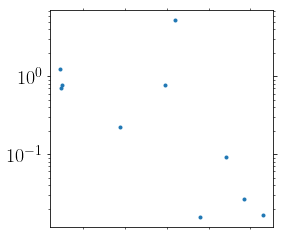

<AxesSubplot:>

In [27]:
stats.stats

,cls_id,size,rg_sq,percTrue
514,515.0,5927.354671,320.071940,0.0
23,24.0,5069.448073,315.201025,0.0
17,18.0,1913.085834,209.917525,0.0
339,340.0,1790.746212,101.717850,0.0
274,275.0,1714.283949,46.185049,0.0
...,...,...,...,...
304,305.0,1.529245,0.000000,0.0
473,474.0,1.529245,0.000000,0.0
104,105.0,1.529245,0.000000,0.0
105,106.0,1.529245,0.000000,0.0


In [6]:
help(utl.PltBinary)

Help on function PltBinary in module utility:

PltBinary(xlin, ylin, zlin, val, box0, thresh=0.0, **kwargs)

